In [2]:
#!/usr/bin/env python3
"""
Script 4: Đánh giá và Visualization kết quả Models
Tạo các biểu đồ so sánh, feature importance, prediction plots
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
os.chdir('..')
import json
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("ĐÁNH GIÁ VÀ VISUALIZATION MODELS")
print("=" * 80)

# ============================================================================
# 1. LOAD DỮ LIỆU VÀ MODELS
# ============================================================================

print("\n" + "=" * 80)
print("BƯỚC 1: LOAD DỮ LIỆU VÀ MODELS")
print("=" * 80)

# Load dữ liệu
print("\n📂 Đang load dữ liệu...")
df = pd.read_parquet("./output/processed_data.parquet")

# Load model info
with open('output/models/model_info.json', 'r') as f:
    model_info = json.load(f)

# Load features info
with open('output/features_info.json', 'r') as f:
    features_info = json.load(f)

# Load label encoders
with open('output/models/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

print("✅ Đã load dữ liệu và models")

ĐÁNH GIÁ VÀ VISUALIZATION MODELS

BƯỚC 1: LOAD DỮ LIỆU VÀ MODELS

📂 Đang load dữ liệu...
✅ Đã load dữ liệu và models


In [3]:
print("\n" + "=" * 80)
print("BƯỚC 2: CHUẨN BỊ DỮ LIỆU TEST")
print("=" * 80)

# Sử dụng cùng subset buildings như khi training
np.random.seed(42)
sample_size = min(10, df['building_id'].nunique())
sample_buildings = np.random.choice(
    df['building_id'].unique(), 
    size=sample_size, 
    replace=False
)
df_test = df[df['building_id'].isin(sample_buildings)].copy()
df_test = df_test.sort_values(['building_id', 'timestamp']).reset_index(drop=True)

# Chia train/test
split_idx = int(len(df_test) * 0.8)
df_test_only = df_test.iloc[split_idx:].copy()

# Tạo features
all_features = (
    features_info['continuous_features'] + 
    features_info['time_features'] + 
    features_info['lag_features']
)
all_features = [f for f in all_features if f in df_test_only.columns]
categorical_features = [f for f in features_info['categorical_features'] if f in df_test_only.columns]

X_test = df_test_only[all_features + categorical_features].copy()
y_test = df_test_only[features_info['target']].copy()


BƯỚC 2: CHUẨN BỊ DỮ LIỆU TEST


In [7]:
categorical_features

['primaryspaceusage', 'sub_primaryspaceusage', 'site_id', 'timezone', 'season']

In [8]:
label_encoders

{'primaryspaceusage': LabelEncoder(),
 'sub_primaryspaceusage': LabelEncoder(),
 'site_id': LabelEncoder(),
 'timezone': LabelEncoder(),
 'season': LabelEncoder()}

In [13]:
le = label_encoders['season']
X_test['season']

,season,season
130024,Spring,Spring
130025,Spring,Spring
130026,Spring,Spring
130027,Spring,Spring
130028,Spring,Spring
...,...,...
162526,Winter,Winter
162527,Winter,Winter
162528,Winter,Winter
162529,Winter,Winter


In [15]:
le.classes_

array(['0', '1', '2', '3'], dtype=object)

In [16]:

# Loại bỏ duplicate columns (nếu có)
if X_test.columns.duplicated().any():
    duplicate_cols = X_test.columns[X_test.columns.duplicated()].tolist()
    print(f"⚠️  Phát hiện duplicate columns: {duplicate_cols}")
    X_test = X_test.loc[:, ~X_test.columns.duplicated()]
    print(f"✅ Đã loại bỏ duplicate columns. Shape mới: {X_test.shape}")

# Đảm bảo tất cả các cột đều là Series 1D
for col in X_test.columns:
    col_data = X_test[col]
    if isinstance(col_data, pd.DataFrame):
        # Nếu là DataFrame, lấy cột đầu tiên
        X_test[col] = col_data.iloc[:, 0]
        print(f"⚠️  Đã sửa cột '{col}' từ DataFrame thành Series")

# Encode categorical
for col in categorical_features:
    if col not in X_test.columns:
        continue
    if col in label_encoders:
        le = label_encoders[col]
        # Đảm bảo là Series 1D
        col_data = X_test[col]
        if isinstance(col_data, pd.DataFrame):
            col_data = col_data.iloc[:, 0]
        elif not isinstance(col_data, pd.Series):
            col_data = pd.Series(col_data, index=X_test.index)
        
        # Convert to string
        col_data = col_data.astype(str)
        
        # Xử lý các giá trị chưa thấy (unknown values)
        mask = ~col_data.isin(le.classes_)
        unknown_count = int(mask.sum())
        if unknown_count > 0:
            # Thay thế các giá trị unknown bằng giá trị đầu tiên trong classes
            col_data.loc[mask] = le.classes_[0]
        
        # Transform
        X_test[col] = le.transform(col_data)

print(f"✅ Test set: {X_test.shape[0]} samples")

⚠️  Phát hiện duplicate columns: ['season']
✅ Đã loại bỏ duplicate columns. Shape mới: (32507, 32)
✅ Test set: 32507 samples


In [17]:
# ============================================================================
# 3. LOAD VÀ PREDICT VỚI CÁC MODELS
# ============================================================================

print("\n" + "=" * 80)
print("BƯỚC 3: PREDICT VỚI CÁC MODELS")
print("=" * 80)

predictions = {}

# Load và predict với từng model
model_files = {
    'XGBoost': 'output/models/xgboost.pkl',
    'LightGBM': 'output/models/lightgbm.pkl',
    'RandomForest': 'output/models/randomforest.pkl',
    'LinearRegression': 'output/models/linearregression.pkl'
}

for model_name, model_path in model_files.items():
    if os.path.exists(model_path):
        print(f"\n📊 Đang predict với {model_name}...")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        if model_name == 'LinearRegression':
            # Cần scale cho Linear Regression
            with open('output/models/scaler.pkl', 'rb') as f:
                scaler = pickle.load(f)
            X_test_scaled = scaler.transform(X_test)
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)
        
        predictions[model_name] = y_pred
        
        # Tính metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        print(f"   RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2%}")



BƯỚC 3: PREDICT VỚI CÁC MODELS

📊 Đang predict với XGBoost...
   RMSE: 210.72, MAE: 113.74, R²: 0.3249, MAPE: 62.75%

📊 Đang predict với LightGBM...
   RMSE: 201.22, MAE: 100.88, R²: 0.3844, MAPE: 35.74%

📊 Đang predict với RandomForest...
   RMSE: 192.44, MAE: 98.66, R²: 0.4369, MAPE: 56.75%

📊 Đang predict với LinearRegression...
   RMSE: 55.76, MAE: 31.84, R²: 0.9527, MAPE: 15.67%


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished



BƯỚC 4: TẠO VISUALIZATIONS

📊 Tạo scatter plots...
✅ Đã lưu: output/visualizations/scatter_actual_vs_predicted.png

📊 Tạo time series plots...
✅ Đã lưu: output/visualizations/time_series_predictions.png

📊 Tạo feature importance plot...
✅ Đã lưu: output/visualizations/feature_importance.png

📊 Tạo residual plots...


KeyError: "None of [Index([ 7224, 27056,  3222, 13386,  5351, 20959,  4840, 25995, 32455,  3694,\n       ...\n       26425, 26200,  1805, 22583, 30950, 13378,  5791, 14172,  6676, 10563],\n      dtype='int64', length=5000)] are in the [index]"

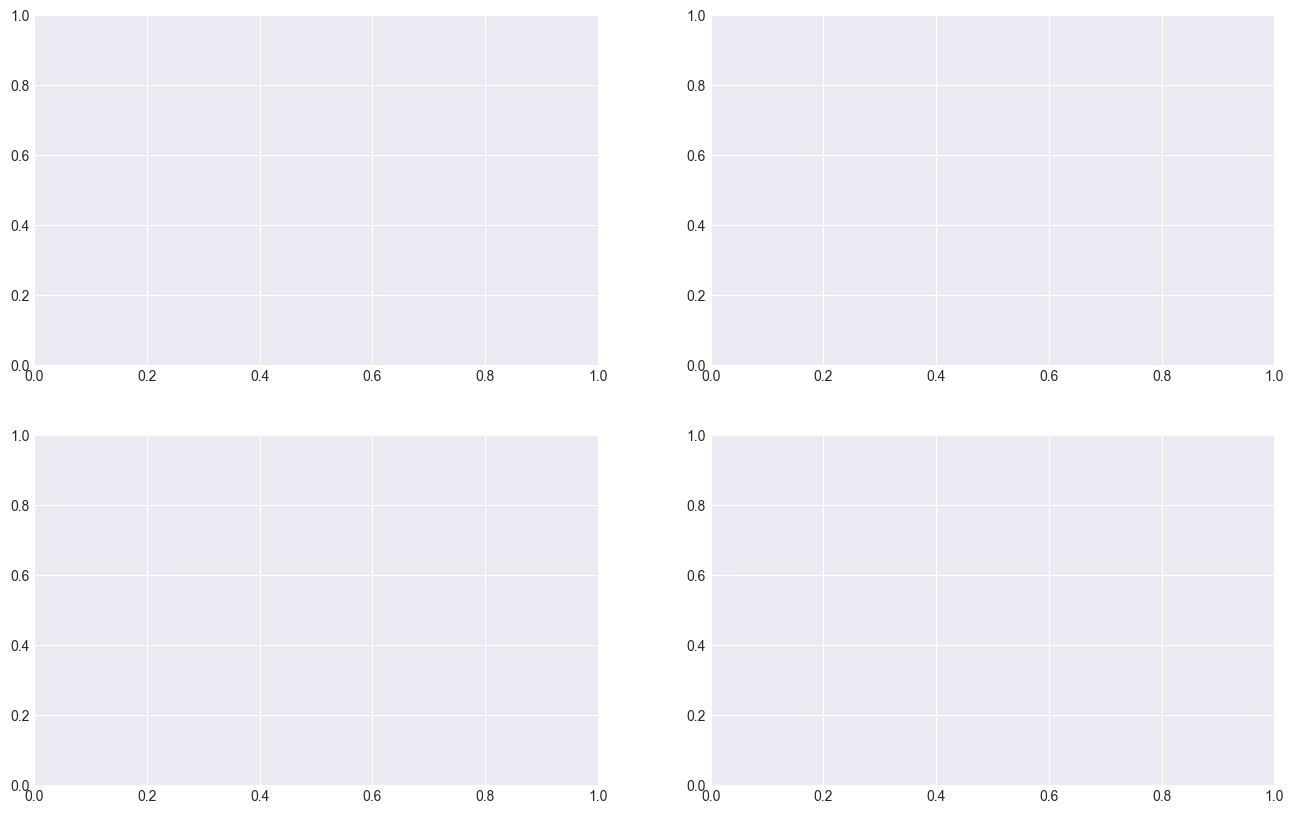

In [18]:
# ============================================================================
# 4. VISUALIZATION - SO SÁNH PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("BƯỚC 4: TẠO VISUALIZATIONS")
print("=" * 80)

os.makedirs('output/visualizations', exist_ok=True)

# 4.1. Scatter plots: Actual vs Predicted
print("\n📊 Tạo scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Sample để plot nhanh hơn
    sample_size = min(5000, len(y_test))
    sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
    
    ax.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=10)
    
    # Đường perfect prediction
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    ax.set_xlabel('Actual Electricity Consumption (kWh)', fontsize=12)
    ax.set_ylabel('Predicted Electricity Consumption (kWh)', fontsize=12)
    ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}, R²: {r2:.4f}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/visualizations/scatter_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
print("✅ Đã lưu: output/visualizations/scatter_actual_vs_predicted.png")
plt.close()

# 4.2. Time series predictions cho một building
print("\n📊 Tạo time series plots...")

sample_building = df_test_only['building_id'].iloc[0]
building_data = df_test_only[df_test_only['building_id'] == sample_building].head(200)

if len(building_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    timestamps = building_data['timestamp'].values
    actual = building_data[features_info['target']].values
    
    for idx, (model_name, y_pred) in enumerate(predictions.items()):
        if idx >= 4:
            break
        
        ax = axes[idx]
        
        # Lấy predictions cho building này
        building_idx = building_data.index - df_test_only.index[0]
        building_pred = y_pred[building_idx]
        
        ax.plot(timestamps, actual, 'b-', label='Actual', linewidth=2, marker='o', markersize=3)
        ax.plot(timestamps, building_pred, 'r-', label='Predicted', linewidth=2, marker='s', markersize=3)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Electricity Consumption (kWh)', fontsize=12)
        ax.set_title(f'{model_name} - Building: {sample_building}', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('output/visualizations/time_series_predictions.png', dpi=150, bbox_inches='tight')
    print("✅ Đã lưu: output/visualizations/time_series_predictions.png")
    plt.close()

# 4.3. Feature Importance (cho XGBoost)
print("\n📊 Tạo feature importance plot...")

if 'XGBoost' in predictions:
    with open('output/models/xgboost.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
    
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 10))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('output/visualizations/feature_importance.png', dpi=150, bbox_inches='tight')
    print("✅ Đã lưu: output/visualizations/feature_importance.png")
    plt.close()

# 4.4. Residual plots
print("\n📊 Tạo residual plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    if idx >= 4:
        break
    
    ax = axes[idx]
    residuals = y_test - y_pred
    
    # Sample để plot nhanh hơn
    sample_size = min(5000, len(residuals))
    sample_idx = np.random.choice(len(residuals), sample_size, replace=False)
    
    ax.scatter(y_pred[sample_idx], residuals[sample_idx], alpha=0.3, s=10)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title(f'{model_name} - Residual Plot', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/visualizations/residual_plots.png', dpi=150, bbox_inches='tight')
print("✅ Đã lưu: output/visualizations/residual_plots.png")
plt.close()

# 4.5. Comparison bar chart
print("\n📊 Tạo comparison bar chart...")

metrics = ['RMSE', 'MAE', 'R²']
comparison_data = []

for model_name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    comparison_data.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

comparison_df = pd.DataFrame(comparison_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('output/visualizations/metrics_comparison.png', dpi=150, bbox_inches='tight')
print("✅ Đã lưu: output/visualizations/metrics_comparison.png")
plt.close()

print("\n" + "=" * 80)
print("HOÀN THÀNH ĐÁNH GIÁ!")
print("=" * 80)
print("✅ Tất cả visualizations đã được lưu trong: output/visualizations/")

